In [11]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from time import perf_counter 
import os

# Defining batch specfications
batch_size = 10
img_height = 224
img_width = 224

# Approach 1: Using CNN
# loading training data
training_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '../data/irisCV',
    validation_split=0.2,
    subset= "training",
    seed=42,
    image_size= (img_height, img_width),
    batch_size=batch_size

)

# loading testing data
validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
'/kaggle/input/iris-computer-vision',
    validation_split=0.2,
    subset= "validation",
    seed=42,
    image_size= (img_height, img_width),
    batch_size=batch_size

)

class_names = training_ds.class_names


# Configuring dataset for performance
AUTOTUNE = tf.data.experimental.AUTOTUNE
training_ds = training_ds.cache().prefetch(buffer_size=AUTOTUNE)
validation_ds = validation_ds.cache().prefetch(buffer_size=AUTOTUNE)

# defining CNN

MyCnn = tf.keras.models.Sequential([
  layers.BatchNormalization(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dense(len(class_names), activation= 'softmax')
])

MyCnn.compile(optimizer='adam',loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# training CNN
retVal = MyCnn.fit(training_ds,validation_data= validation_ds,epochs = 5)

Found 421 files belonging to 3 classes.
Using 337 files for training.
Found 421 files belonging to 3 classes.
Using 84 files for validation.
Epoch 1/5
34/34 [==============================] - 25s 741ms/step - loss: 1.9065 - accuracy: 0.5757 - val_loss: 0.8698 - val_accuracy: 0.6548
Epoch 2/5
34/34 [==============================] - 24s 716ms/step - loss: 0.9781 - accuracy: 0.6350 - val_loss: 1.0269 - val_accuracy: 0.6548
Epoch 3/5
34/34 [==============================] - 25s 737ms/step - loss: 0.8963 - accuracy: 0.6350 - val_loss: 0.9816 - val_accuracy: 0.6548
Epoch 4/5
34/34 [==============================] - 25s 729ms/step - loss: 0.8651 - accuracy: 0.6350 - val_loss: 0.9698 - val_accuracy: 0.6548
Epoch 5/5
34/34 [==============================] - 25s 724ms/step - loss: 0.8404 - accuracy: 0.6706 - val_loss: 0.9265 - val_accuracy: 0.6429


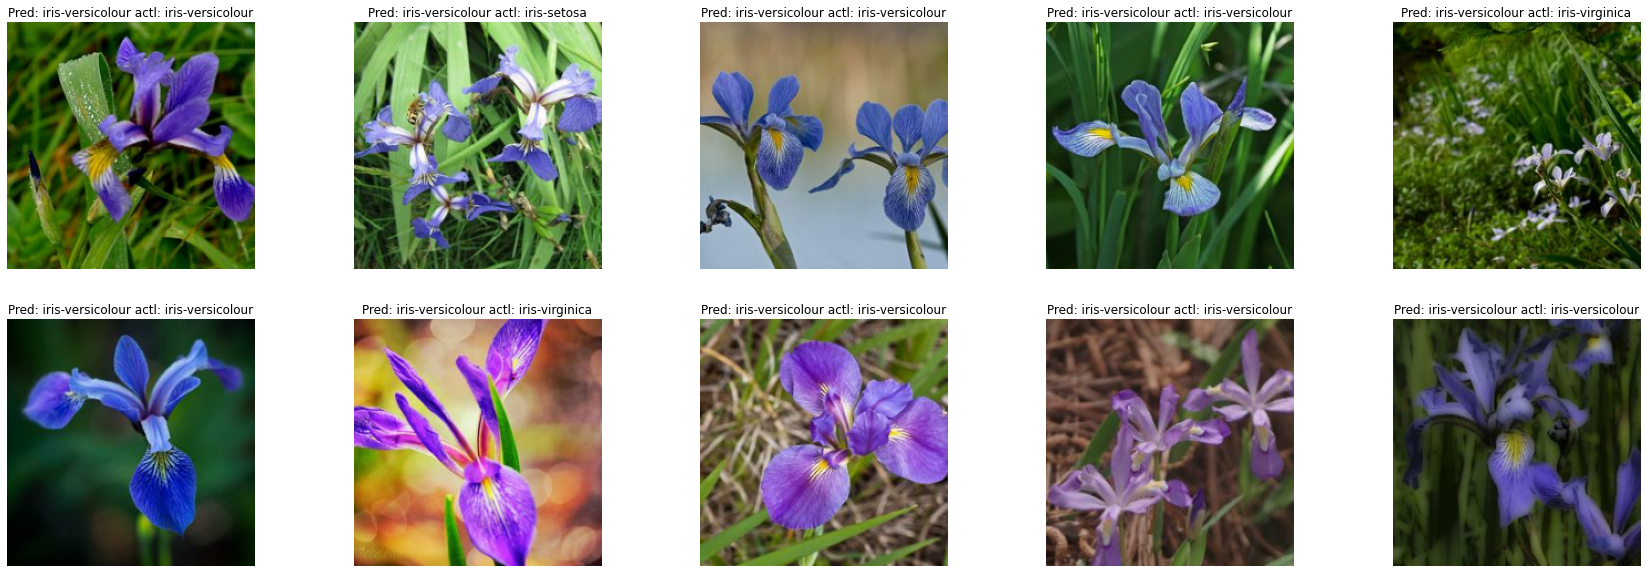

In [19]:
# plotting results
plt.figure(figsize=(30, 10))
for images, labels in validation_ds.take(1):
    predictions = MyCnn.predict(images)
    predlabel = []
    prdlbl = []
    
    for mem in predictions:
        predlabel.append(class_names[np.argmax(mem)])
        prdlbl.append(np.argmax(mem))
    
    AccuracyVector = np.array(prdlbl) == labels
    for i in range(10):
        ax = plt.subplot(2, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title('Pred: '+ predlabel[i]+' actl: '+class_names[labels[i]] )
        plt.axis('off')
        plt.grid(True)

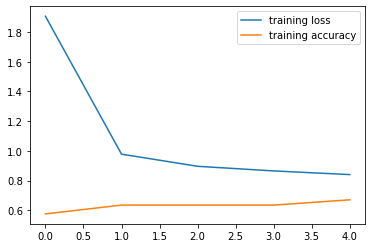

In [14]:
# training loss
plt.plot(retVal.history['loss'], label = 'training loss')
plt.plot(retVal.history['accuracy'], label = 'training accuracy')
plt.legend()

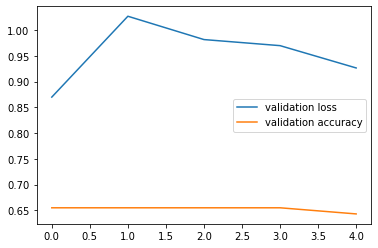

In [15]:
# validation loss and accuracy 
plt.plot(retVal.history['val_loss'], label = 'validation loss')
plt.plot(retVal.history['val_accuracy'], label = 'validation accuracy')
plt.legend()

In [25]:
# Approach 2: Transfer learning using InceptionResnetV2                    

import keras
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Dense, Flatten
from tensorflow.keras.models import Model

pretrained = InceptionResNetV2(include_top=True,weights='imagenet')
x=pretrained.layers[-2].output
predLayer = Dense(len(class_names),activation='softmax')(x)
MyCnn = Model(inputs=pretrained.input,outputs=predLayer)

# freezing initial layers
for layer in MyCnn.layers[:-40] :
    layer.trainable = False
    

MyCnn.compile(optimizer='adam',loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# learning rate rescheduling
def scheduler(epoch, lr):
    if epoch < 2:
        return lr
    else:
        return lr * 0.3
    
    
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
# lets train our model
retVal = MyCnn.fit(training_ds, validation_data=validation_ds, callbacks=[callback], epochs= 5)

Epoch 1/5
34/34 [==============================] - 59s 2s/step - loss: 1.3077 - accuracy: 0.5697 - val_loss: 6.0800 - val_accuracy: 0.6548
Epoch 2/5
34/34 [==============================] - 55s 2s/step - loss: 0.9825 - accuracy: 0.6113 - val_loss: 1.9338 - val_accuracy: 0.6429
Epoch 3/5
34/34 [==============================] - 56s 2s/step - loss: 0.9293 - accuracy: 0.6380 - val_loss: 0.9478 - val_accuracy: 0.6548
Epoch 4/5
34/34 [==============================] - 55s 2s/step - loss: 0.8867 - accuracy: 0.6320 - val_loss: 0.9757 - val_accuracy: 0.5833
Epoch 5/5
34/34 [==============================] - 55s 2s/step - loss: 0.8762 - accuracy: 0.6350 - val_loss: 0.9321 - val_accuracy: 0.6548


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


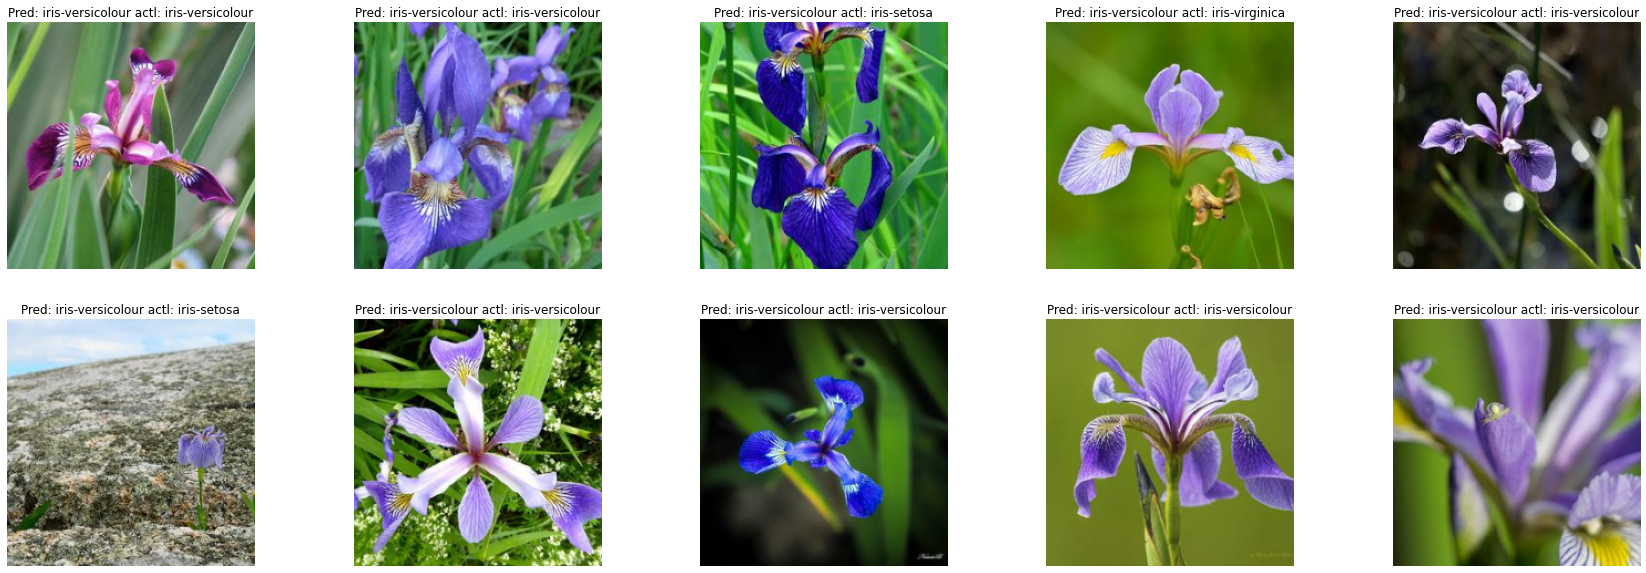

In [30]:
# plotting results
plt.figure(figsize=(30, 10))
for images, labels in validation_ds.take(3):
    predictions = MyCnn.predict(images)
    predlabel = []
    prdlbl = []
    
    for mem in predictions:
        predlabel.append(class_names[np.argmax(mem)])
        prdlbl.append(np.argmax(mem))
    
    AccuracyVector = np.array(prdlbl) == labels
    for i in range(10):
        ax = plt.subplot(2, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title('Pred: '+ predlabel[i]+' actl: '+class_names[labels[i]] )
        plt.axis('off')
        plt.grid(True)

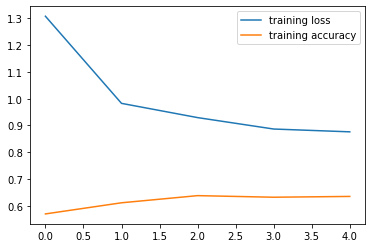

In [31]:
# training loss
plt.plot(retVal.history['loss'], label = 'training loss')
plt.plot(retVal.history['accuracy'], label = 'training accuracy')
plt.legend()

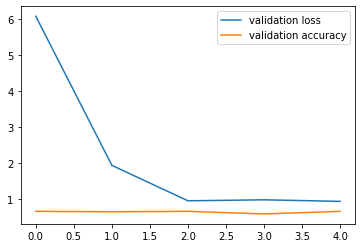

In [32]:
# validation loss and accuracy 
plt.plot(retVal.history['val_loss'], label = 'validation loss')
plt.plot(retVal.history['val_accuracy'], label = 'validation accuracy')
plt.legend()

In [ ]:
#  Approach 3 : using a pretrained CNN and Kmeans clustering

DataFrame = {
    'photo_name' : [],
    'flattenPhoto' : [],
    'class' : []
    }

# Loading model
MyModel = tf.keras.models.Sequential()
MyModel.add(tf.keras.applications.ResNet101(
    include_top = False, weights='imagenet', pooling='avg',))

# freezing weights for 1st layer
MyModel.layers[0].trainable = False

import cv2
# Now defining dataloading Function
def LoadDataAndDoEssentials(path, h, w):
    img = cv2.imread(path)
    img = cv2.resize(img, (h, w))
    # Expanding image dims so this represents 1 sample
    img = img = np.expand_dims(img, 0)
    
    img = tf.keras.applications.resnet50.preprocess_input(img)
    extractedFeatures = MyModel.predict(img)
    extractedFeatures = np.array(extractedFeatures)
    DataFrame['flattenPhoto'].append(extractedFeatures.flatten())
    
# iterrator function
def ReadAndStoreMyImages(path, cls):
    list_ = os.listdir(path)

    for mem in list_:
        DataFrame['photo_name'].append(mem)
        DataFrame['class'].append(cls)
        imagePath = path + '/' + mem
        LoadDataAndDoEssentials(imagePath, 224, 224)

# loading data into our ds
path1 = '/kaggle/input/iris-computer-vision/iris-setosa'
path2 = '/kaggle/input/iris-computer-vision/iris-versicolour'
path3 = '/kaggle/input/iris-computer-vision/iris-virginica'


ReadAndStoreMyImages(path1, 'setosa')
ReadAndStoreMyImages(path2, 'versicolour')
ReadAndStoreMyImages(path3, 'virginica')


In [41]:
# Clustering

Training_Feature_vector = np.array(DataFrame['flattenPhoto'], dtype = 'float64')
from sklearn.cluster import AgglomerativeClustering
kmeans = AgglomerativeClustering(n_clusters = 3)
kmeans.fit(Training_Feature_vector)

AgglomerativeClustering(n_clusters=3)

In [42]:
kmeans.labels_

array([2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 2,
       0, 0, 2, 1, 2, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 2, 0, 0, 2, 0,
       2, 0, 0, 0, 2, 2, 0, 2, 0, 2, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 0, 0,
       0, 2, 1, 1, 0, 2, 0, 0, 2, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 2, 0, 0, 0, 0, 1, 1, 1, 0, 0, 2, 0,
       0, 2, 0, 0, 0, 2, 0, 0, 2, 1, 1, 0, 2, 2, 2, 2, 0, 1, 1, 1, 0, 1,
       1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 2, 0, 1, 2, 0, 1, 2, 1,
       0, 2, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 2, 2, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 2, 0, 0, 1, 2, 0, 0,
       1, 1, 1, 0, 0, 0, 2, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0,
       0, 0, 0, 2, 2, 1, 0, 2, 0, 0, 0, 1, 1, 2, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 2, 1, 0, 1, 0, 1, 2, 0, 1, 1, 0, 2, 1,

In [43]:
# lets draw some conclusions form the above
def drawConclusions():
    zeroCount = 0 
    oneCount = 0
    twoCount = 0

    for mem in kmeans.labels_ :
        if mem == 0:
            zeroCount += 1
        elif mem == 1:
            oneCount += 1
        elif mem == 2:
            twoCount += 1
            
    per0 = zeroCount / len(kmeans.labels_)
    per1 = oneCount / len(kmeans.labels_)
    per2 = twoCount / len(kmeans.labels_)
    
    print ('No. of samples classified in category zero: ' + str(zeroCount) + ' and their % is : ' + str(per0))
    print ('No. of samples classified in category one: ' + str(oneCount) + ' and their % is : ' + str(per1))
    print ('No. of samples classified in category two: ' + str(twoCount) + ' and their % is : ' + str(per2))
    
drawConclusions()

No. of samples classified in category zero: 269 and their % is : 0.6389548693586699
No. of samples classified in category one: 92 and their % is : 0.21852731591448932
No. of samples classified in category two: 60 and their % is : 0.14251781472684086


In [46]:
predictions = kmeans.labels_
classPred = []
for mem in predictions:
    if mem == 0:
        classPred.append('versicolour')
    elif mem == 1:
        classPred.append('virginica')
    elif mem == 2:
        classPred.append('setosa')


In [48]:
# let calculate accuracy
acc = 0
for trueLabel, predictedLabel in zip(DataFrame['class'], classPred):
    if trueLabel == predictedLabel:
        acc += 1

print ('Accuracy for third approach is {}'.format(acc/421))

Accuracy for third approach is 0.4584323040380047
